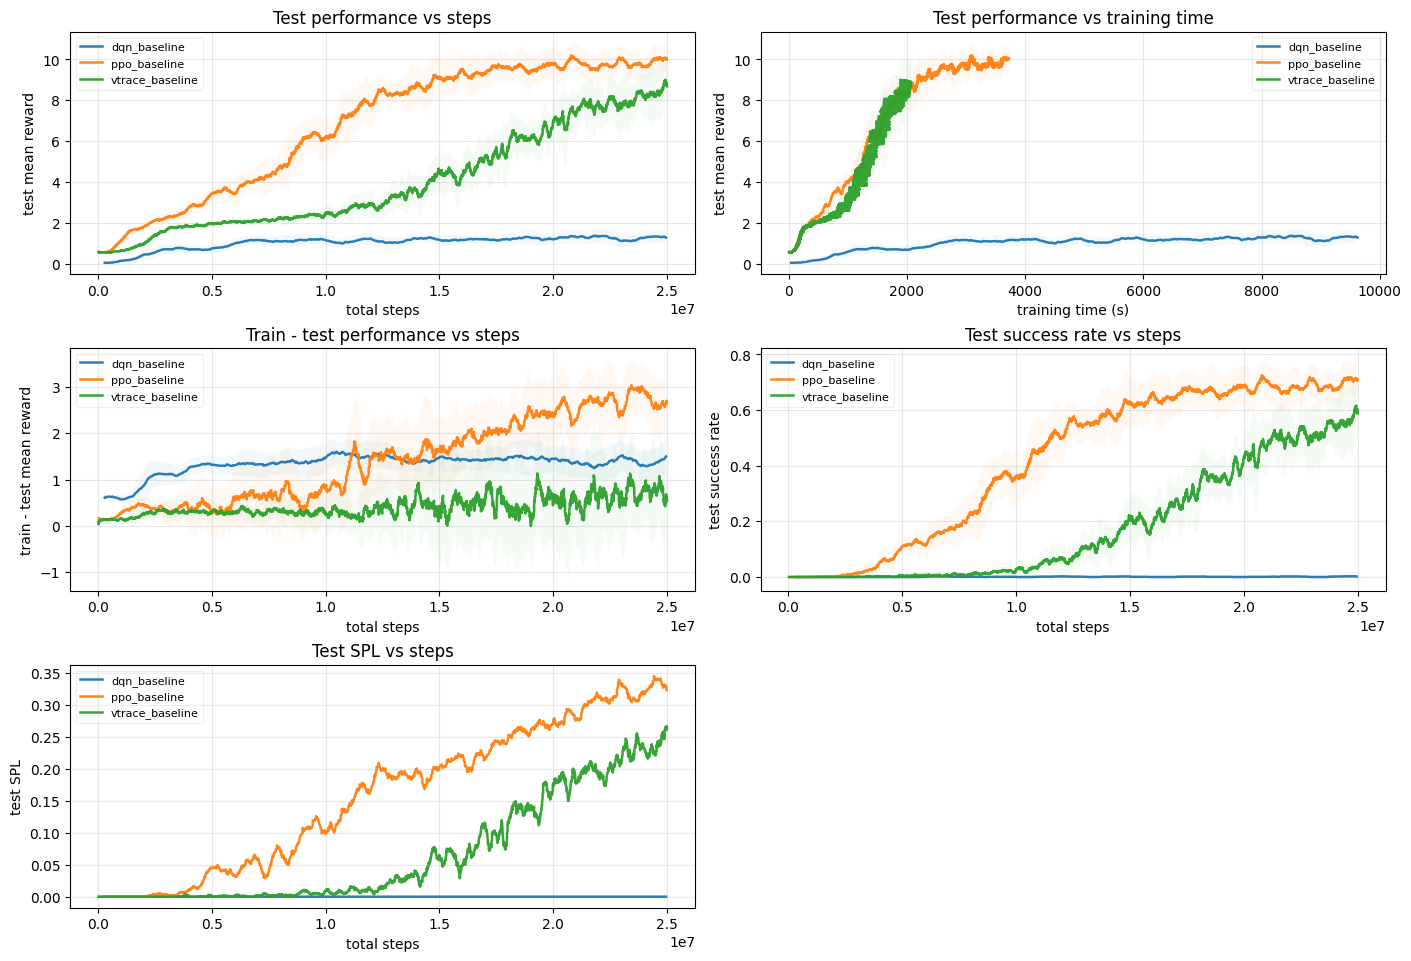

In [1]:

# ...existing code...
# (full replacement for the 3rd code cell)

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging

ROOT_DIR = "./compare"
CSV_NAME = "sit_format.csv"

# Only the columns we actually need
REQUIRED_COLS = [
    "training_time",
    "total_steps",
    "test/mean_reward",
    "train/mean_reward",
    "test/success",
    "test/spl",
]

# 5 plots
PLOTS = [
    {
        "x": "total_steps",
        "y": "test/mean_reward",
        "xlabel": "total steps",
        "ylabel": "test mean reward",
        "title": "Test performance vs steps",
    },
    {
        "x": "training_time",
        "y": "test/mean_reward",
        "xlabel": "training time (s)",
        "ylabel": "test mean reward",
        "title": "Test performance vs training time",
    },
    {
        "x": "total_steps",
        "y": "train_test_gap",
        "xlabel": "total steps",
        "ylabel": "train - test mean reward",
        "title": "Train - test performance vs steps",
    },
    {
        "x": "total_steps",
        "y": "test/success",
        "xlabel": "total steps",
        "ylabel": "test success rate",
        "title": "Test success rate vs steps",
    },
    {
        "x": "total_steps",
        "y": "test/spl",
        "xlabel": "total steps",
        "ylabel": "test SPL",
        "title": "Test SPL vs steps",
    },
]

ROLL_WINDOW = 25          # smoothing window for non-SPL
UNCERTAINTY_SCALE = 1.0   # std-band scale
BAND_ALPHA = 0.05         # band transparency

logging.basicConfig(level=logging.INFO, format="%(levelname)s | %(message)s")
logger = logging.getLogger("sit_plot_simple_cluster")


def find_run_csvs(root, csv_name):
    paths = []
    for dirpath, _, filenames in os.walk(root):
        if csv_name in filenames:
            paths.append(os.path.join(dirpath, csv_name))
    return sorted(paths)


def infer_run_name(path, root):
    rel = os.path.relpath(os.path.dirname(path), root)
    return rel.replace("\\", "/")


def infer_base_run_name(run_name: str) -> str:
    """
    Group everything that only differs by seed into one base name.

    Handles:
      ppo_baseline_seed_1_fruitbot   -> ppo_baseline_fruitbot
      ppo_baseline_seed_2_fruitbot   -> ppo_baseline_fruitbot
      some/dir/seed_3                -> some/dir
      rnd_p0.1_m1.0_seed_3           -> rnd_p0.1_m1.0
    """
    parts = run_name.split("/")
    last = parts[-1]

    # Case 1: whole last component is 'seed_X'
    if re.fullmatch(r"seed_\d+", last):
        base = "/".join(parts[:-1])
        return base if base else run_name

    # Case 2: last component ends with '_seed_X'
    m = re.search(r"^(.*)_seed_\d+$", last)
    if m:
        parts[-1] = m.group(1)
        return "/".join(parts)

    # Case 3: last component has '_seed_X_' in the middle, e.g. 'ppo_baseline_seed_1_fruitbot'
    m2 = re.search(r"^(.*)_seed_\d+_(.*)$", last)
    if m2:
        parts[-1] = f"{m2.group(1)}_{m2.group(2)}"
        return "/".join(parts)

    # Fallback: no seed pattern found
    return run_name


def ensure_numeric(series, name):
    if series is None:
        raise ValueError(f"Column '{name}' missing")
    v = pd.to_numeric(series, errors="coerce").astype(float).values
    if v.size == 0 or not np.isfinite(v).any():
        raise ValueError(f"Column '{name}' has no finite numeric values")
    return v


def smooth_series(y, window):
    s = pd.Series(y, dtype=float)
    # allow early points, we just want some smoothing not strict window coverage
    return s.rolling(window, min_periods=1).mean().values


def uncertainty_series(y, window):
    s = pd.Series(y, dtype=float)
    std = s.rolling(window, min_periods=max(2, window // 2)).std(ddof=1)
    return std.values


def load_runs(root):
    """
    Load all seed runs.

    - For reward/success: average across seeds per (base_run, total_steps, training_time).
    - For SPL: use ONLY seed_1 per base_run (no seed averaging).
    """
    paths = find_run_csvs(root, CSV_NAME)
    if not paths:
        logger.error(f"No CSVs named '{CSV_NAME}' found under root='{root}'")
        return pd.DataFrame()

    per_seed_frames = []
    spl_seed1_frames = []

    for p in paths:
        run = infer_run_name(p, root)
        base_run = infer_base_run_name(run)

        try:
            df = pd.read_csv(p)
            missing = [c for c in REQUIRED_COLS if c not in df.columns]
            if missing:
                raise ValueError(f"Missing required columns: {missing}")

            t_time = ensure_numeric(df["training_time"], "training_time")
            steps = ensure_numeric(df["total_steps"], "total_steps")
            test_mean = ensure_numeric(df["test/mean_reward"], "test/mean_reward")
            train_mean = ensure_numeric(df["train/mean_reward"], "train/mean_reward")
            success = ensure_numeric(df["test/success"], "test/success")
            spl = ensure_numeric(df["test/spl"], "test/spl")

            train_test_gap = train_mean - test_mean

            # common metrics (averaged across seeds)
            sub_common = pd.DataFrame(
                {
                    "run": run,
                    "base_run": base_run,
                    "training_time": t_time,
                    "total_steps": steps,
                    "test/mean_reward": test_mean,
                    "train/mean_reward": train_mean,
                    "train_test_gap": train_test_gap,
                    "test/success": success,
                }
            )
            sub_common = sub_common.sort_values("total_steps")
            per_seed_frames.append(sub_common)

            # SPL: keep only seed_1 for each base_run (others ignored)
            if "seed_1" in run:
                sub_spl = pd.DataFrame(
                    {
                        "base_run": base_run,
                        "training_time": t_time,
                        "total_steps": steps,
                        "test/spl": spl,
                    }
                )
                sub_spl = sub_spl.sort_values("total_steps")
                spl_seed1_frames.append(sub_spl)

        except Exception as e:
            logger.error(f"[{run}] skipping due to error: {e}")
            continue

    if not per_seed_frames:
        logger.error("No valid runs loaded after strict validation")
        return pd.DataFrame()

    df_seeds = pd.concat(per_seed_frames, ignore_index=True)

    # aggregate non-SPL metrics across seeds
    group_cols = ["base_run", "total_steps", "training_time"]
    numeric_cols = [
        "test/mean_reward",
        "train/mean_reward",
        "train_test_gap",
        "test/success",
    ]
    df_agg = (
        df_seeds.groupby(group_cols, as_index=False)[numeric_cols]
        .mean(numeric_only=True)
    )

    # merge SPL from seed_1 only (no averaging across seeds)
    if spl_seed1_frames:
        df_spl = pd.concat(spl_seed1_frames, ignore_index=True)
        df_spl = (
            df_spl.groupby(["base_run", "total_steps", "training_time"], as_index=False)[
                ["test/spl"]
            ]
            .mean(numeric_only=True)
        )
        df_agg = df_agg.merge(
            df_spl,
            on=["base_run", "total_steps", "training_time"],
            how="left",
        )
    else:
        df_agg["test/spl"] = np.nan

    df_agg = df_agg.rename(columns={"base_run": "run"})
    return df_agg


def nice_run_label(run: str) -> str:
    """
    Shorten run name for legend:
      - drop trailing '_fruitbot' / '_chaser'
      - drop preceding directory components
    """
    base = run.split("/")[-1]
    for suffix in ("_fruitbot", "_chaser"):
        if base.endswith(suffix):
            base = base[: -len(suffix)]
    return base


def plot_runs(ax, df, runs, x, y, xlabel, ylabel, title):
    plotted_any = False
    is_spl = (y == "test/spl")

    # use the same window for everything (including SPL)
    window = ROLL_WINDOW

    for r in runs:
        d = df[df["run"] == r]
        if d.empty:
            continue

        xv = d[x].values
        yv = d[y].values

        if yv.size == 0 or np.all(~np.isfinite(yv)):
            logger.error(f"[{r}] plot '{title}' y='{y}' invalid; skipping")
            continue

        ys = smooth_series(yv, window)

        # no band for SPL, keep band for others
        if is_spl:
            u = None
        else:
            u = uncertainty_series(yv, window)

        # for SPL we only require x and smoothed y to be finite
        mask = np.isfinite(xv) & np.isfinite(ys)
        xv2, ys2 = xv[mask], ys[mask]
        if xv2.size == 0:
            logger.error(f"[{r}] plot '{title}' insufficient finite points")
            continue

        label = nice_run_label(r)
        ax.plot(xv2, ys2, label=label, linewidth=1.8, alpha=0.95)

        if not is_spl and u is not None:
            mband = mask & np.isfinite(u)
            if np.any(mband):
                ax.fill_between(
                    xv[mband],
                    ys[mband] - UNCERTAINTY_SCALE * u[mband],
                    ys[mband] + UNCERTAINTY_SCALE * u[mband],
                    alpha=BAND_ALPHA,
                    linewidth=0,
                )

        plotted_any = True

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    if plotted_any:
        ax.legend(loc="best", fontsize=8, framealpha=0.3)
    else:
        logger.error(f"No lines plotted for '{title}'")

def main():
    df = load_runs(ROOT_DIR)
    if df.empty:
        print(f"No {CSV_NAME} files with required columns found under: {ROOT_DIR}")
        return

    runs = df["run"].unique().tolist()
    if not runs:
        print(f"No valid runs after strict validation under: {ROOT_DIR}")
        return

    # ---------- 1) Save each plot as its own PDF (good for report) ----------
    out_dir = "plots_pdf"
    os.makedirs(out_dir, exist_ok=True)

    for i, cfg in enumerate(PLOTS):
        fig, ax = plt.subplots(
            1,
            1,
            figsize=(6, 4),  # good aspect for 2-up on A4
            constrained_layout=True,
        )
        plot_runs(ax, df, runs, **cfg)

        safe_title = (
            cfg["title"]
            .lower()
            .replace(" ", "_")
            .replace("/", "_")
            .replace("(", "")
            .replace(")", "")
        )
        fname = f"{i+1:02d}_{safe_title}.pdf"
        fpath = os.path.join(out_dir, fname)
        fig.savefig(fpath, format="pdf")
        plt.close(fig)

    # ---------- 2) Also show the 3x2 overview grid interactively ----------
    rows, cols = 3, 2  # 5 plots → 3x2 grid, last axis removed
    fig, axes = plt.subplots(rows, cols, figsize=(14, 9.5), constrained_layout=True)
    axes = axes.flatten()

    for i, cfg in enumerate(PLOTS):
        plot_runs(axes[i], df, runs, **cfg)

    for j in range(len(PLOTS), rows * cols):
        fig.delaxes(axes[j])

    plt.show()


if __name__ == "__main__":
    main()